In [1]:
!pip install catboost

In [6]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/3a/d8/4d4ae25452577f2dfabc66b60e712e7c01f9fe6c389fa88c546c2f427c4d/xgboost-3.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.6/72.0 MB 17.9 MB/s eta 0:00:04
   - -------------------------------------- 2.2/72.0 MB 27.2 MB/s eta 0:00:03
   -- ------------------------------------- 4.7/72.0 MB 37.4 MB/s eta 0:00:02
   --- ------------------------------------ 6.7/72.0 MB 35.7 MB/s eta 0:00:02
   ---- ----------------------------------- 8.9/72.0 MB 40.7 MB/s eta 0:00:02
   ----- ---------------------------------- 9.8/72.0 MB 39.3 MB/s eta 0:00:02
   ----- ---------------------------------- 10.4/72.0 MB 36.4 MB/s eta 0:00:02
   ------ --------------------------------- 10.8/72.0 MB 36.3 MB/s eta 0:00:02
   ------ --------------------------------- 11.6/72.0 MB 34.4 MB/s eta 0:00:02
   ------ ----------

===============================
STEP 0: IMPORTS & CONFIGURATION
===============================

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

===============================
STEP 1: LOAD DATA
===============================

In [2]:
train = pd.read_csv("train_av.csv")
test = pd.read_csv("test_av.csv")

train["source"] = "train"
test["source"] = "test"

data = pd.concat([train, test], ignore_index=True)

# Why

# Combine train & test for consistent preprocessing

# Still safe because target is untouched

===============================
STEP 2: BASIC DATA UNDERSTANDING (EDA)
===============================

In [3]:
data.info()
data.describe()

# Check:

# Missing values

# Data types

# Numerical ranges

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


=============================== STEP 2.1: CATEGORICAL CARDINALITY CHECK ===============================

In [4]:
print("\nCategorical Cardinality Check\n")

categorical_cols_check = [
    "Item_Identifier",
    "Outlet_Identifier",
    "Item_Type",
    "Outlet_Type",
    "Outlet_Size",
    "Outlet_Location_Type"
]

cardinality_df = pd.DataFrame({
    "Feature": categorical_cols_check,
    "Unique_Count": [data[col].nunique() for col in categorical_cols_check],
    "Total_Rows": len(data)
})

cardinality_df["Cardinality_%"] = (
    cardinality_df["Unique_Count"] / cardinality_df["Total_Rows"] * 100
).round(2)

cardinality_df = cardinality_df.sort_values(
    by="Unique_Count", ascending=False
)

print(cardinality_df)


Categorical Cardinality Check

                Feature  Unique_Count  Total_Rows  Cardinality_%
0       Item_Identifier          1559       14204          10.98
2             Item_Type            16       14204           0.11
1     Outlet_Identifier            10       14204           0.07
3           Outlet_Type             4       14204           0.03
4           Outlet_Size             3       14204           0.02
5  Outlet_Location_Type             3       14204           0.02


===============================
STEP 3: TARGET VARIABLE ANALYSIS
===============================

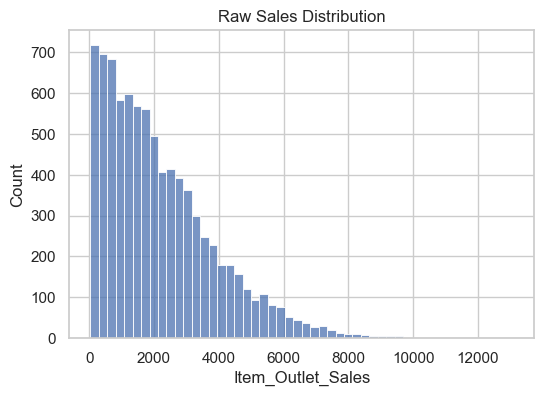

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(train["Item_Outlet_Sales"], bins=50)
plt.title("Raw Sales Distribution")
plt.show()

# Observation

# Highly right-skewed

# RMSE will be dominated by large values

# Log transformation (industry standard)

In [6]:
train["log_sales"] = np.log1p(train["Item_Outlet_Sales"])

In [7]:
train["log_sales"].head()

0    8.225808
1    6.096776
2    7.648868
3    6.597664
4    6.903451
Name: log_sales, dtype: float64

=============================== STEP 3.1: FEATURE RELATIONSHIPS (EDA) ===============================


 Correlation Matrix (Numerical Features)



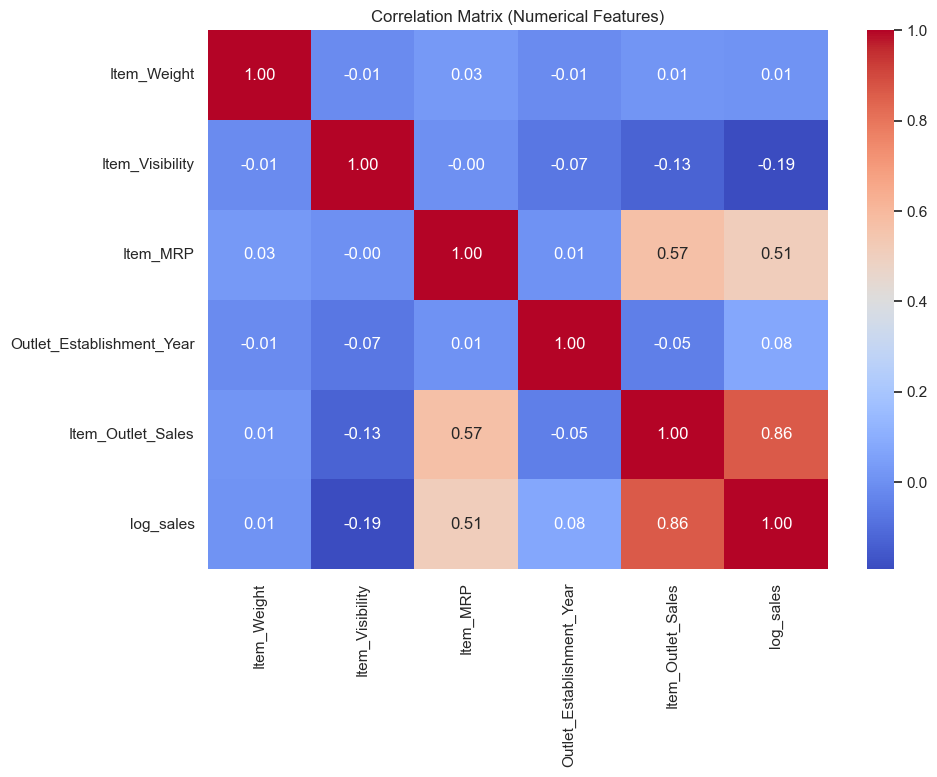

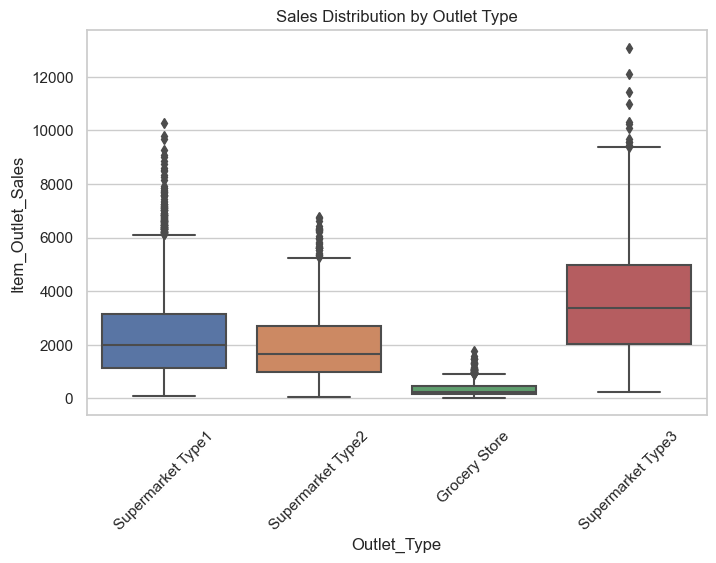

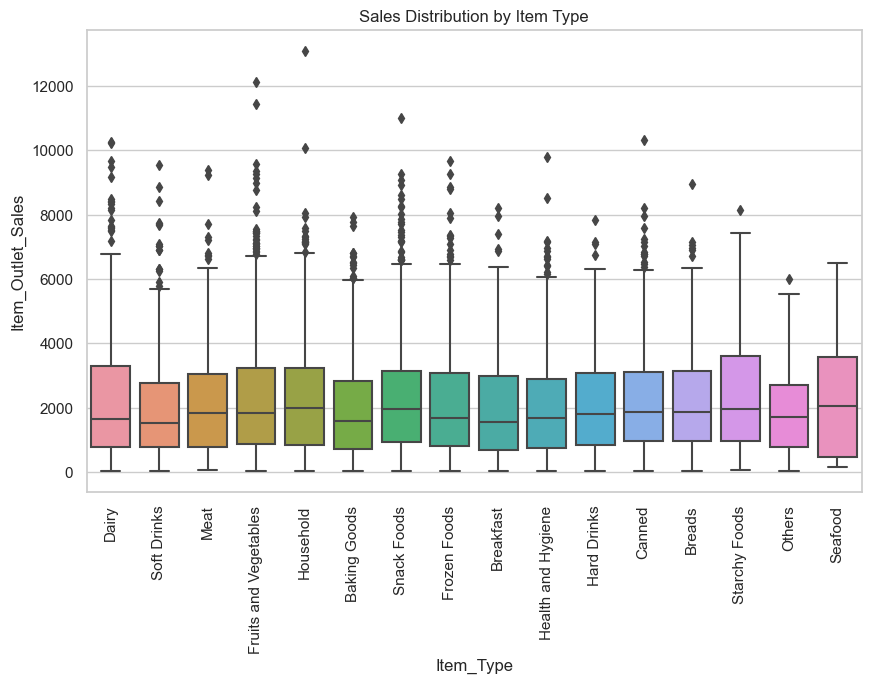

In [8]:
print("\n Correlation Matrix (Numerical Features)\n")

# Select only numerical columns
numeric_cols = train.select_dtypes(include=[np.number]).columns

# Remove target raw if you want separate view
corr_matrix = train[numeric_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()


# --------------------------------------
# Boxplot: Sales vs Outlet_Type
# --------------------------------------

plt.figure(figsize=(8,5))
sns.boxplot(
    x="Outlet_Type",
    y="Item_Outlet_Sales",
    data=train
)
plt.xticks(rotation=45)
plt.title("Sales Distribution by Outlet Type")
plt.show()


# --------------------------------------
# Boxplot: Sales vs Item_Type
# --------------------------------------

plt.figure(figsize=(10,6))
sns.boxplot(
    x="Item_Type",
    y="Item_Outlet_Sales",
    data=train
)
plt.xticks(rotation=90)
plt.title("Sales Distribution by Item Type")
plt.show()

===============================
STEP 4: MISSING VALUE TREATMENT
===============================

In [9]:
#4.1 Item_Weight (product-specific)
item_weight_median = data.groupby("Item_Identifier")["Item_Weight"].median()

data["Item_Weight"] = data.apply(
    lambda x: item_weight_median[x["Item_Identifier"]]
    if pd.isnull(x["Item_Weight"]) else x["Item_Weight"],
    axis=1
)

data["Item_Weight"].fillna(data["Item_Weight"].median(), inplace=True)


# Why

# Weight is intrinsic to product

# Preserves physical meaning

In [10]:
# 4.2 Outlet_Size (store attribute)

outlet_size_mode = data.groupby("Outlet_Type")["Outlet_Size"].agg(
    lambda x: x.mode()[0]
)

data["Outlet_Size"] = data.apply(
    lambda x: outlet_size_mode[x["Outlet_Type"]]
    if pd.isnull(x["Outlet_Size"]) else x["Outlet_Size"],
    axis=1
)

In [11]:
#4.3 Item_Visibility = 0 (data error)
visibility_median = data.groupby("Item_Identifier")["Item_Visibility"].median()

data.loc[data["Item_Visibility"] == 0, "Item_Visibility"] = \
    data.loc[data["Item_Visibility"] == 0, "Item_Identifier"].map(visibility_median)

===============================
STEP 5: FEATURE ENGINEERING
===============================

In [12]:
#5.1 Product category

# First 2 characters of item code define category:

# FD → Food

# DR → Drinks

# NC → Non-Consumable
data["Item_Category"] = data["Item_Identifier"].str[:2]



#5.2 Outlet age

# Dataset year = 2013

# Converts year into age of outlet

# “Older outlets sell more”
# better than:

# “Lower year value sells more”

data["Outlet_Age"] = 2013 - data["Outlet_Establishment_Year"]

#5.3 Price features

#MRP is right-skewed

# Log:

# Compresses large values

# Makes relationship more linear

#log1p Handles zero safely:
    
data["Item_MRP_log"] = np.log1p(data["Item_MRP"])

# Divides MRP into quartiles

# Each bin has ~equal number of observations

# Captures non-linear pricing effects

# Some outlets may sell:

# Premium products better than low-priced ones

data["Item_MRP_bin"] = pd.qcut(
    data["Item_MRP"], q=4, labels=["Low", "Medium", "High", "Premium"]
)

#5.4 Visibility ratio
#Computes average visibility per product

#Visibility Ratio=Current Visibility/Typical Visibility of Item

avg_visibility = data.groupby("Item_Identifier")["Item_Visibility"].mean()
data["Item_Visibility_Ratio"] = data["Item_Visibility"] / data["Item_Identifier"].map(avg_visibility)


===============================
STEP 6: ENCODING CATEGORICAL VARIABLES
===============================

In [13]:
categorical_cols = [
    "Item_Identifier", "Item_Type", "Item_Category",
    "Outlet_Identifier", "Outlet_Size",
    "Outlet_Location_Type", "Outlet_Type",
    "Item_MRP_bin"
]

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    
    
# Why

# Label encoding works best for tree models

# Avoids one-hot explosion

===============================
STEP 7: SPLIT BACK TRAIN & TEST
===============================

In [14]:
train_final = data[data["source"] == "train"].copy()
test_final = data[data["source"] == "test"].copy()

train_final["log_sales"] = np.log1p(train_final["Item_Outlet_Sales"])

===============================
STEP 8: FEATURE LIST (FINAL)
===============================

In [15]:
features = [
    "Item_Weight",
    "Item_Visibility",
    "Item_Visibility_Ratio",
    "Item_MRP",
    "Item_MRP_log",
    "Item_MRP_bin",
    "Outlet_Age",
    "Item_Category",
    "Item_Type",
    "Outlet_Identifier",
    "Outlet_Size",
    "Outlet_Location_Type",
    "Outlet_Type"
]

===============================
STEP 9: K-FOLD WITH LEAKAGE-SAFE AGGREGATION
===============================

In [16]:
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_cat = np.zeros(len(train_final))

test_preds_cat = np.zeros(len(test_final))


===============================
STEP 10: CROSS-VALIDATION LOOP
===============================

In [17]:
for fold, (tr_idx, val_idx) in enumerate(kf.split(train_final)):
    print(f"\nFold {fold + 1}")

    tr = train_final.iloc[tr_idx].copy()
    val = train_final.iloc[val_idx].copy()

    # ---- Leakage-safe aggregation ----
    item_avg = tr.groupby("Item_Identifier")["Item_Outlet_Sales"].mean()
    outlet_avg = tr.groupby("Outlet_Identifier")["Item_Outlet_Sales"].mean()

    for df in [tr, val, test_final]:
        df["Item_Avg_Sales"] = df["Item_Identifier"].map(item_avg)
        df["Outlet_Avg_Sales"] = df["Outlet_Identifier"].map(outlet_avg)

        df["Item_Avg_Sales"].fillna(tr["Item_Avg_Sales"].median(), inplace=True)
        df["Outlet_Avg_Sales"].fillna(tr["Outlet_Avg_Sales"].median(), inplace=True)

    fold_features = features + ["Item_Avg_Sales", "Outlet_Avg_Sales"]

    X_tr, y_tr = tr[fold_features], tr["log_sales"]
    X_val, y_val = val[fold_features], val["log_sales"]

    # ---- CatBoost ----
    cat = CatBoostRegressor(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        loss_function="RMSE",
        #random_seed=42,
        verbose=False
    )

    cat.fit(X_tr, y_tr)
    oof_cat[val_idx] = cat.predict(X_val)
    test_preds_cat += cat.predict(test_final[fold_features]) / N_FOLDS


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5


In [18]:
##predicted valuses - log scale
test_preds_cat

array([7.43203395, 7.28394867, 6.4083372 , ..., 7.4449447 , 8.10978537,
       7.34588289])

===============================
STEP 11: MODEL Evaluation Matrix (RMSE) 
===============================

In [19]:
rmse_cat = mean_squared_error(train_final["log_sales"], oof_cat, squared=False)

print(f"CatBoost CV RMSE (log): {rmse_cat:.4f}")


CatBoost CV RMSE (log): 0.5870


In [20]:
#Step 1: Back-transform predictions
oof_cat_raw = np.expm1(oof_cat)


#Step 2: Get true raw target
y_true_raw = train_final["Item_Outlet_Sales"].values

#Step 3: Compute RMSE on original scale
rmse_cat_raw = mean_squared_error(
    y_true_raw,
    oof_cat_raw,
    squared=False
)

print(f"CatBoost CV RMSE (raw): {rmse_cat_raw:,.2f}")

CatBoost CV RMSE (raw): 1,271.85


===============================
STEP 12: FEATURE IMPORTANCE (CatBoost)
===============================

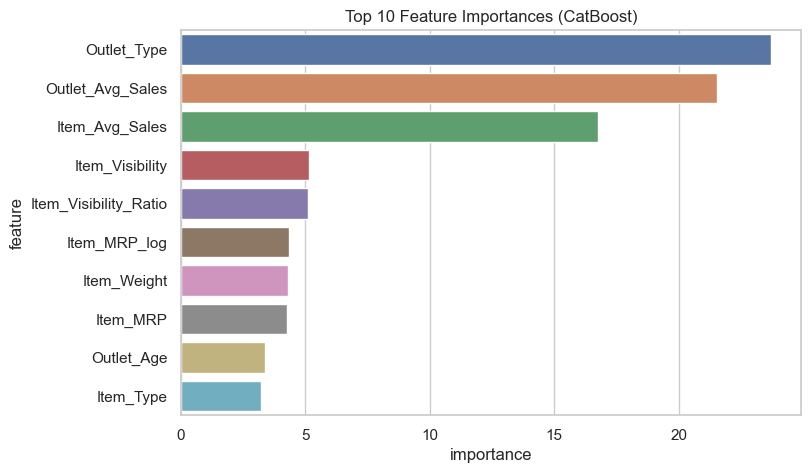

In [21]:
feat_imp = pd.DataFrame({
    "feature": fold_features,
    "importance": cat.get_feature_importance()
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=feat_imp.head(10))
plt.title("Top 10 Feature Importances (CatBoost)")
plt.show()

===============================
STEP 13: FINAL PREDICTION & SUBMISSION
===============================

In [22]:
final_preds = np.expm1(test_preds_cat)

submission = pd.DataFrame({
    "Item_Identifier": test["Item_Identifier"],
    "Outlet_Identifier": test["Outlet_Identifier"],
    "Item_Outlet_Sales": final_preds
})

submission.to_csv("final_submission.csv", index=False)